In [42]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm

from data.make_dataset import ImageDataset
from models import UNet, AttentionUNet, TransformerUNet
from utils.Metrics import Metrics
from utils.losses import DiceBCELoss
from utils.plot import plot_losses
from utils.config import DTYPE, get_device
from utils.config import ACCURACY, AUPRC, AUROC_, DICE_SCORE, F1_SCORE, JACCARD_INDEX, PRECISION, RECALL, SPECIFICITY

from train import train
from evaluate import evaluate

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
device = get_device()

In [44]:
train_dataset = ImageDataset("../data/raw/Br35H-Mask-RCNN/TRAIN", "../data/raw/Br35H-Mask-RCNN/TRAIN_MASK")
val_dataset = ImageDataset("../data/raw/Br35H-Mask-RCNN/VAL", "../data/raw/Br35H-Mask-RCNN/VAL_MASK")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [47]:
train_metrics = Metrics(device, 2)
val_metrics = Metrics(device, 2)
epochs = 15

train_loss = []
val_loss = []

model = AttentionUNet((1, 32, 64, 128, 256, 512), True, True).to(device)
criterion = DiceBCELoss(device).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.15, patience=2)

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}/{epochs}')
    train_metrics.reset()
    val_metrics.reset()
    t1, t2 = train(model, criterion, optimizer, device, train_loader, train_metrics)
    train_loss.extend(t1)
    val_loss.append(evaluate(model, criterion, device, val_loader, val_metrics))
    scheduler.step(val_loss[-1])
    train_agg_metrics = train_metrics.compute()
    val_agg_metrics = val_metrics.compute()

    print(f'Training   - Accuracy: {train_agg_metrics[ACCURACY]:.4f} | Dice: {train_agg_metrics[DICE_SCORE]:.4f} | IoU: {train_agg_metrics[JACCARD_INDEX]:.4f} | Loss: {t2:.4f}')
    print(f'Validation - Accuracy: {val_agg_metrics[ACCURACY]:.4f} | Dice: {val_agg_metrics[DICE_SCORE]:.4f} | IoU: {val_agg_metrics[JACCARD_INDEX]:.4f} | Loss: {val_loss[-1]:.4f}')
    print()

Epoch 1/15

Validation: 100%|██████████| 7/7 [00:00<00:00,  9.41it/s, Accuracy=0.9575, Dice=0.0000, IoU=0.4787, Loss=1.0403]

Training   - Accuracy: 0.9507 | Dice: 0.2045 | IoU: 0.5321 | Loss: 0.8069
Validation - Accuracy: 0.9519 | Dice: 0.0045 | IoU: 0.4771 | Loss: 1.0314

Epoch 2/15


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.08it/s, Accuracy=0.4369, Dice=0.1274, IoU=0.2404, Loss=2.5328]

Training   - Accuracy: 0.9607 | Dice: 0.4680 | IoU: 0.6327 | Loss: 0.5541
Validation - Accuracy: 0.4790 | Dice: 0.1542 | IoU: 0.2683 | Loss: 2.5115

Epoch 3/15


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.71it/s, Accuracy=0.8344, Dice=0.2393, IoU=0.4830, Loss=1.7095]

Training   - Accuracy: 0.9629 | Dice: 0.5139 | IoU: 0.6540 | Loss: 0.5188
Validation - Accuracy: 0.7121 | Dice: 0.2310 | IoU: 0.4148 | Loss: 1.7638

Epoch 4/15


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.74it/s, Accuracy=0.9614, Dice=0.4123, IoU=0.6103, Loss=0.6968]

Training   - Accuracy: 0.9652 | Dice: 0.5641 | IoU: 0.6786 | Loss: 0.4930
Validation - Accuracy: 0.9347 | Dice: 0.5213 | IoU: 0.6424 | Loss: 0.6975

Epoch 5/15


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.88it/s, Accuracy=0.9575, Dice=0.0000, IoU=0.4787, Loss=1.1165]

Training   - Accuracy: 0.9674 | Dice: 0.6078 | IoU: 0.7016 | Loss: 0.4448
Validation - Accuracy: 0.9519 | Dice: 0.0025 | IoU: 0.4766 | Loss: 1.1149

Epoch 6/15


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.96it/s, Accuracy=0.9630, Dice=0.3954, IoU=0.6045, Loss=0.5514]

Training   - Accuracy: 0.9662 | Dice: 0.5976 | IoU: 0.6957 | Loss: 0.4517
Validation - Accuracy: 0.9613 | Dice: 0.6226 | IoU: 0.7060 | Loss: 0.5362

Epoch 7/15


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.85it/s, Accuracy=0.9582, Dice=0.0342, IoU=0.4878, Loss=1.1193]

Training   - Accuracy: 0.9666 | Dice: 0.5896 | IoU: 0.6919 | Loss: 0.4552
Validation - Accuracy: 0.9519 | Dice: 0.0058 | IoU: 0.4774 | Loss: 1.1217

Epoch 8/15


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.74it/s, Accuracy=0.9594, Dice=0.1575, IoU=0.5223, Loss=0.7638]

Training   - Accuracy: 0.9684 | Dice: 0.6239 | IoU: 0.7104 | Loss: 0.4075
Validation - Accuracy: 0.9564 | Dice: 0.1904 | IoU: 0.5307 | Loss: 0.7537

Epoch 9/15


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.59it/s, Accuracy=0.9580, Dice=0.0261, IoU=0.4856, Loss=1.0565]

Training   - Accuracy: 0.9691 | Dice: 0.6366 | IoU: 0.7175 | Loss: 0.4068
Validation - Accuracy: 0.9521 | Dice: 0.0162 | IoU: 0.4801 | Loss: 1.0525

Epoch 10/15


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.88it/s, Accuracy=0.9635, Dice=0.2640, IoU=0.5577, Loss=0.5515]

Training   - Accuracy: 0.9679 | Dice: 0.5922 | IoU: 0.6939 | Loss: 0.4088
Validation - Accuracy: 0.9636 | Dice: 0.4378 | IoU: 0.6216 | Loss: 0.5283

Epoch 11/15


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.47it/s, Accuracy=0.9630, Dice=0.2605, IoU=0.5562, Loss=0.6325]

Training   - Accuracy: 0.9731 | Dice: 0.7022 | IoU: 0.7566 | Loss: 0.3326
Validation - Accuracy: 0.9612 | Dice: 0.3639 | IoU: 0.5916 | Loss: 0.6208

Epoch 12/15


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.89it/s, Accuracy=0.9636, Dice=0.2785, IoU=0.5625, Loss=0.5459]

Training   - Accuracy: 0.9746 | Dice: 0.7237 | IoU: 0.7704 | Loss: 0.3083
Validation - Accuracy: 0.9646 | Dice: 0.4604 | IoU: 0.6315 | Loss: 0.5262

Epoch 13/15


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.71it/s, Accuracy=0.9645, Dice=0.3871, IoU=0.6021, Loss=0.4531]

Training   - Accuracy: 0.9751 | Dice: 0.7263 | IoU: 0.7723 | Loss: 0.2957
Validation - Accuracy: 0.9693 | Dice: 0.5887 | IoU: 0.6929 | Loss: 0.4321

Epoch 14/15


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.84it/s, Accuracy=0.9649, Dice=0.3044, IoU=0.5721, Loss=0.5723]

Training   - Accuracy: 0.9768 | Dice: 0.7512 | IoU: 0.7888 | Loss: 0.2787
Validation - Accuracy: 0.9630 | Dice: 0.4103 | IoU: 0.6103 | Loss: 0.5575

Epoch 15/15


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.15it/s, Accuracy=0.9682, Dice=0.4376, IoU=0.6240, Loss=0.4131]

Training   - Accuracy: 0.9775 | Dice: 0.7594 | IoU: 0.7944 | Loss: 0.2727
Validation - Accuracy: 0.9715 | Dice: 0.6355 | IoU: 0.7183 | Loss: 0.3897



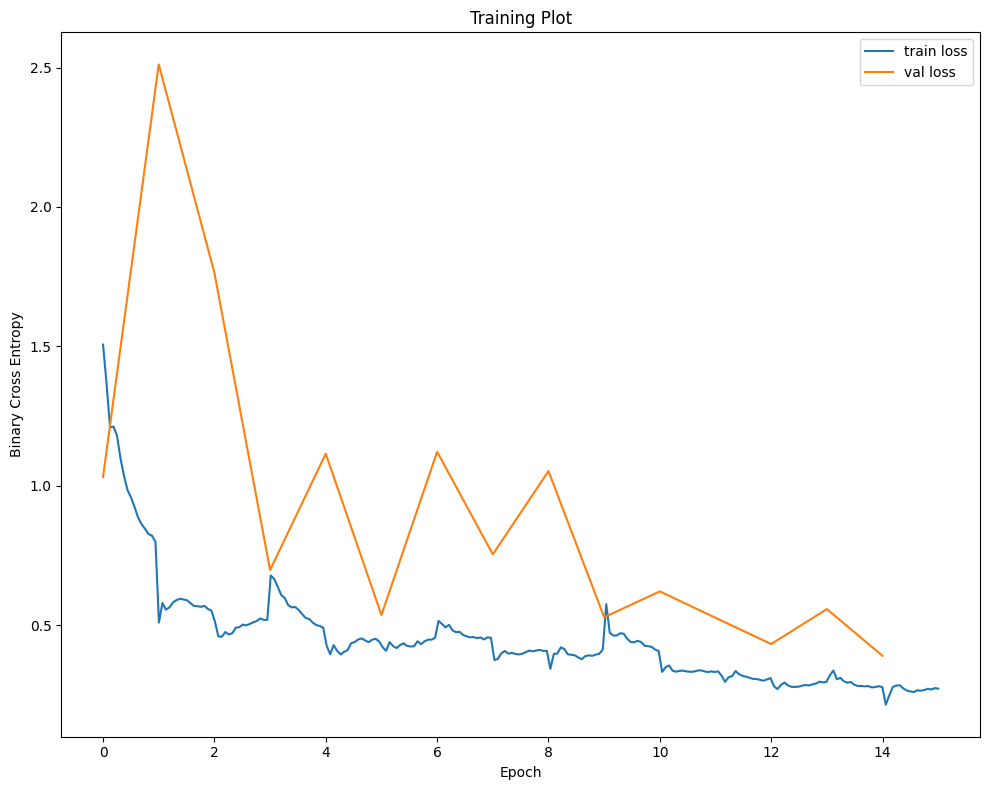

In [48]:
plot_losses(train_loss, val_loss)